# Monte Carlo Methods Project

## Getting started

To run the code, first install Julia:

1. Visit https://julialang.org/downloads/ and select the installer for your system (I used 1.8.3, but probably 1.9.0 will work just as well). If you're on Linux, run:

   ```bash
   wget https://julialang-s3.julialang.org/bin/linux/x64/1.8/julia-1.8.3-linux-x86_64.tar.gz
   tar zxvf julia-1.8.3-linux-x86_64.tar.gz
   ```

2. On Linux, that's all you have to do. You can choose to make the `julia` executable more accessible by, e.g., opening `~/.bashrc` and adding the line:

   ```bash
   export PATH="$PATH:/path/to/<Julia directory>/bin"
   ```

3. Make sure to start a new terminal or run `source ~/.bashrc` afterwards.

Consequently, you want to install the relevant packages:

1. Move one level above the current directory (the current directory is the one that contains this file) and activate Julia:

   ```bash
   cd ..
   julia
   ```

2. Inside Julia, change to the Pkg mode by typing `]`. In there, you want to activate the project toml file and instantiate the project. This will install all necessary packages and precompile them.

   ```julia
   ]
   activate mcm_project
   instantiate
   ```

## Running the code

If you have Visual Studio Code installed, you could open the `project.ipynb` file, select Julia as your notebook kernel, and then hopefully be able to run everything cell by cell. Slightly simpler would be to run the more barebones `project.jl`, which contains some additional code to create an `images` directory and save the generated images as png files. To use the last option, run:

```bash
cd mcm_project
julia --project=. project.jl
```

## Dependencies

In [69]:
using LinearAlgebra
using Distributions
using Plots

General note: It was not quite clear to me whether the starting values should be returned by the sampling algorithms, or discarded. Either way, I don't think it matters much, but I decided to be prudent and discard the starting values.

## Exercise (a)

In [70]:
function quadraticpotential_grad(q)
    q
end

function leapfrog(q0, p0, tau, l, mass, potential_grad::Function)
    # Determine dimensionality
    d = length(q0)

    # Also accomodate initial values
    qs = [Vector{Float64}(undef, d) for _ = 1:(l+1)]
    ps = [Vector{Float64}(undef, d) for _ = 1:(l+1)]

    qs[1] = q0
    ps[1] = p0

    for i = 2:(l+1)
        p_half = ps[i - 1] .- tau / 2 .* potential_grad(qs[i - 1])
        qs[i] = qs[i - 1] .+ tau * inv(mass) * p_half
        ps[i] = p_half .- tau / 2 .* potential_grad(qs[i])
    end

    # Discard initial value
    (qs[2:(l+1)], ps[2:(l+1)])
end

leapfrog (generic function with 1 method)

## Exercise (b)

In [71]:
q0 = [0.]
p0 = [1.]
tau = 1.2
l = 20
mass = [1.;;]

(ps1, qs1) = leapfrog(q0, p0, tau, l, mass, quadraticpotential_grad)

tau = 0.3
l = 80

(ps2, qs2) = leapfrog(q0, p0, tau, l, mass, quadraticpotential_grad);

In [72]:
qs1_flat = [v[1] for v in qs1]
ps1_flat = [v[1] for v in ps1]

qs2_flat = [v[1] for v in qs2]
ps2_flat = [v[1] for v in ps2];

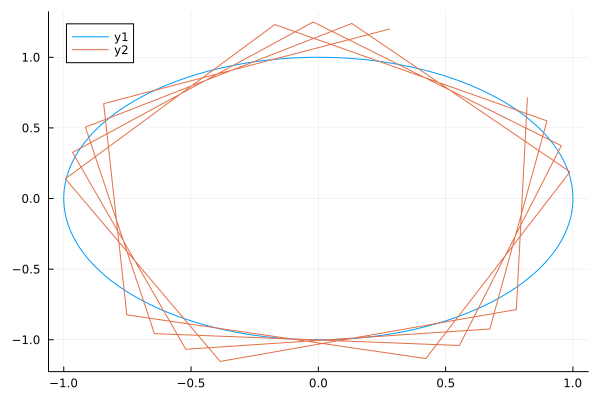

In [73]:
t = collect(0:0.01:2π)
q_exact = -cos.(t .+ π/2)
p_exact = sin.(t .+ π/2)

plot(q_exact, p_exact)
plot!(qs1_flat, ps1_flat)

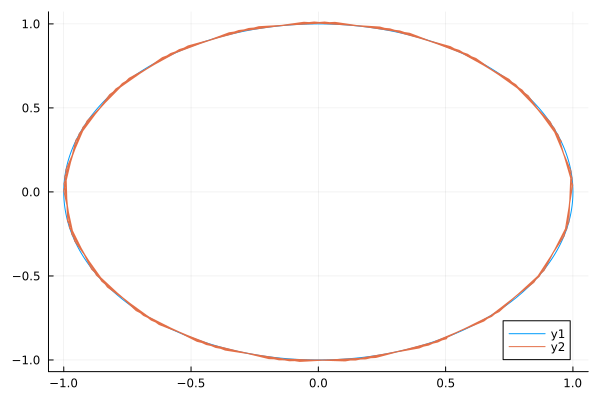

In [74]:
plot(q_exact, p_exact)
plot!(qs2_flat, ps2_flat)

## Exercise (c)

Substituting Equation (4) into (7), and then using Equation (8), we get:

\begin{align*}
\pi(\mathbf{q}, \mathbf{p}) &\propto \exp\left(-H(\mathbf{q}, \mathbf{p})\right) \\
&\propto e^{-U(\mathbf{q}) - K(\mathbf{p})} \\
&\propto e^{ -- ln(\pi(\mathbf{q})) } e^{ -\frac{1}{2} \mathbf{p}^T M^{-1} \mathbf{p} } \\
&\propto \pi(\mathbf{q}) e^{ -\frac{1}{2} \mathbf{p}^T M^{-1} \mathbf{p} }.
\end{align*}

If we fix $\mathbf{p}$, we can treat it as a constant:

\begin{align*}
\pi(\mathbf{q} \mid \mathbf{p}) &\propto
\pi(\mathbf{q}) e^{ -\frac{1}{2} \mathbf{p}^T M^{-1} \mathbf{p} } \\
&\propto \pi(\mathbf{q}).
\end{align*}

This shows that sampling from $\pi(\mathbf{q}, \mathbf{p})$ is equivalent to sampling from $\pi(\mathbf{q})$ if $\mathbf{p}$ is fixed.

## Exercise (d)

Fixing $\mathbf{q}$ to specify a pdf for $\mathbf{p}$ yields:

\begin{align*}
\pi(\mathbf{p} \mid \mathbf{q}) &\propto \pi(\mathbf{q}) e^{ -\frac{1}{2} \mathbf{p}^T M^{-1} \mathbf{p} } \\
&\propto e^{ -\frac{1}{2} \mathbf{p}^T M^{-1} \mathbf{p} } \\
&\propto (2\pi)^{-d / 2} \det\left( M \right)^{-1/2} e^{ -\frac{1}{2} \mathbf{p}^T M^{-1} \mathbf{p} }.
\end{align*}

In other words, $\pi(\mathbf{p} \mid \mathbf{q})$ is equal to a 0-mean multivariate Gaussian pdf up to a normalising constant. $M$ can be interpreted as the covariance matrix of that Gaussian.

## Exercise (e)

$-H(\mathbf{q}^*, \mathbf{p}^*) + H(\mathbf{q}, \mathbf{p})$ can be interpreted as $\frac{\Delta H}{\Delta t}$. We have seen above that with an exact trajectory, the Hamiltonian is conserved: $\frac{dH}{dt} = 0$. Under this condition, the acceptance probability becomes:

\begin{align*}
\alpha &= \min\left\{ 1,\, \exp\left( -H(\mathbf{q}^*, \mathbf{p}^*) + H(\mathbf{q}, \mathbf{p}) \right) \right\} \\
&= \min\left\{ 1,\, \exp(0) \right\} \\
&= 1.
\end{align*}

This means that using an approach that approximates the trajectory well would lead to acceptance probabilities close to 1.

## Exercise (f)

In [75]:
function quadraticpotential(q)
    0.5 * q' * q
end

function hamiltonian(q, p, mass, potential::Function)
    potential(q) + 0.5 * p' * inv(mass) * p
end

function hmc(n, q0, tau_dist, l, potential::Function, potential_grad::Function)
    # Determine dimensionality
    d = length(q0)

    # Also accomodate initial values
    qs = [Vector{Float64}(undef, d) for _ = 1:(n+1)]
    ps = [Vector{Float64}(undef, d) for _ = 1:(n+1)]

    # Julia can infer the size of I from the mathematical context
    mass = I
    norm = MvNormal(zeros(Float64, d), mass)

    qs[1] = q0

    for t = 2:(n+1)
        ps[t - 1] = vec(rand(norm, 1))

        tau = rand(tau_dist, 1)[1]
        # Note that qs_star has a different dimensionality (l) than qs (n)
        (qs_star, ps_star) = leapfrog(qs[t - 1], ps[t - 1], tau, l, mass, potential_grad)
        q_star = qs_star[l]
        p_star = ps_star[l]

        h_prev = hamiltonian(qs[t - 1], ps[t - 1], mass, potential)
        h_star = hamiltonian(q_star, p_star, mass, potential)

        alpha = min(1, exp(h_prev - h_star))

        if rand() < alpha
            qs[t] = q_star
            ps[t] = p_star
        else
            qs[t] = qs[t - 1]
            ps[t] = ps[t - 1]
        end
    end

    (qs[2:(n+1)], ps[2:(n+1)])
end

hmc (generic function with 1 method)

Testing with the quadratic potential and its gradient. Since we are not applying a -log to to the potential, we are essentially sampling from:

\begin{align*}
\pi(\mathbf{q} \mid \mathbf{p}) &\propto e^{-U(\mathbf{q}) - K(\mathbf{p})} \\
&\propto e^{-U(\mathbf{q})} \\
&\propto e^{-\frac{1}{2}\mathbf{q}^T\mathbf{q}},
\end{align*}

which is proportional to a multivariate normal pdf with mean 0 and covariance matrix $I$. In other words, we should get a normal distribution if we set $d = 1$, which the histogram below shows to be the case.

In [76]:
tau_dist = Uniform(0.5, 1.5)
samples, _ = hmc(100000, q0, tau_dist, l, quadraticpotential, quadraticpotential_grad);

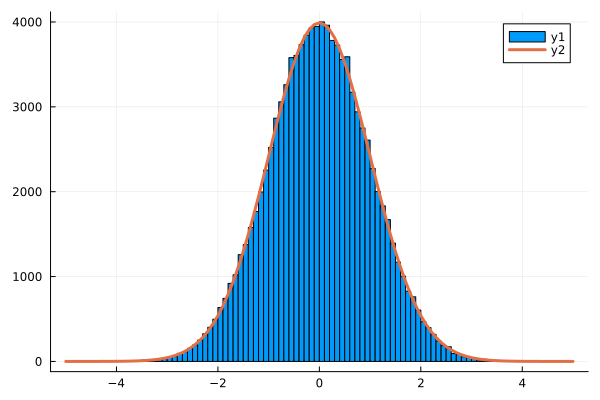

In [77]:
samples_flat = [s[1] for s in samples]
histogram(samples_flat)

x = -5:0.1:5
plot!(x, pdf.(Normal(0, 1), x) .* 1e4, linewidth = 3)

## Exercise (g)

In [78]:
function rw_mh(n, start, prop_dist, target::Function)
    d = length(start)

    samples = [Vector{Float64}(undef, d) for _ = 1:(n+1)]
    samples[1] = start

    for i = 2:(n+1)
        sample_prop = vec(rand(prop_dist, 1)) + samples[i - 1]

        dens_prev = target(samples[i - 1])
        dens_prop = target(sample_prop)
        alpha = min(1, dens_prop / dens_prev)

        if rand() < alpha
            samples[i] = sample_prop
        else
            samples[i] = samples[i - 1]
        end
    end

    samples[2:(n+1)]
end

rw_mh (generic function with 1 method)

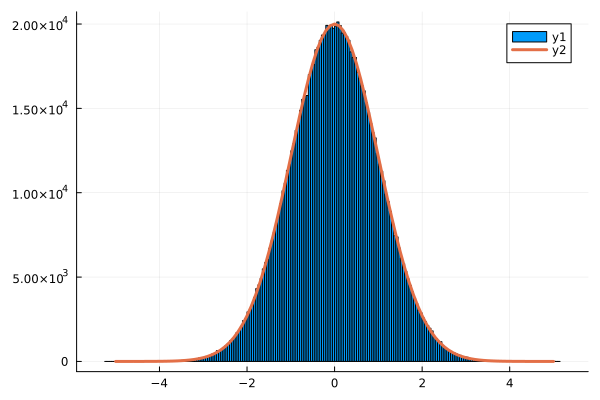

In [79]:
target(x) = exp(-quadraticpotential(x))
samples = rw_mh(1000000, [0.], MvNormal(zeros(1), I), target)
histogram([s[1] for s in samples])

x = -5:0.1:5
plot!(x, target.(x) .* 2e4, linewidth = 3)

## Exercise (h)

In [80]:
function rand_sigma_mh(n, start, sigma_dist, target::Function)
    mh_samples = [Vector{Float64}(undef, d) for _ = 1:(n+1)]
    mh_samples[1] = start

    mu = zeros(size(start))

    for i = 2:(n+1)
        sigma = rand(sigma_dist, 1)[1]
        prop_dist = MvNormal(mu, sigma * I)

        mh_samples[i] = rw_mh(1, mh_samples[i - 1], prop_dist, target)[1]
    end

    mh_samples[2:(n+1)]
end

rand_sigma_mh (generic function with 1 method)

To be able to use Hamiltonian Monte Carlo, we first need to find the gradient $\nabla_\mathbf{q} U$. Since

\begin{equation*}
\nabla_\mathbf{q} U = 
    \begin{pmatrix}
    \frac{\partial U}{\partial q_1} \\
    \vdots \\
    \frac{\partial U}{\partial q_d}
    \end{pmatrix},
\end{equation*}

we need to find $\frac{\partial U}{\partial q_i}$, where $i = 1,\, \dots,\, d$. Because we want to sample from a multivariate normal, we get the -log of its pdf:

\begin{align*}
\frac{\partial U}{\partial q_i} &= \frac{\partial}{\partial q_i} \left[ -\log \left( (2\pi)^{-\frac{d}{2}} \det(\Sigma)^{-\frac{1}{2}} e^{-\frac{1}{2} \mathbf{q}^T \Sigma^{-1} \mathbf{q}} \right) \right] \\
&= \frac{\partial}{\partial q_i} \left[ - \left( \log \left( (2\pi)^{-\frac{d}{2}} \det(\Sigma)^{-\frac{1}{2}} \right) + \log \left( e^{-\frac{1}{2} \mathbf{q}^T \Sigma^{-1} \mathbf{q}} \right) \right) \right] \\
&= \frac{\partial}{\partial q_i} \left[ \frac{1}{2} \mathbf{q}^T \Sigma^{-1} \mathbf{q} \right].
\end{align*}

$\Sigma$ is diagonal, so its inverse can be found by taking the reciprocals of its diagonal values:

\begin{align*}
\frac{\partial U}{\partial q_i} &= \frac{\partial}{\partial q_i} \left[ \frac{1}{2} \mathbf{q}^T 
    \begin{pmatrix}
    \frac{1}{\sigma_1} & \dots & 0 \\
    \vdots & \ddots & \vdots \\
    0 & \dots & \frac{1}{\sigma_d}
    \end{pmatrix}
\mathbf{q} \right] \\
&= \frac{\partial}{\partial q_i} \left[ \frac{1}{2} \mathbf{q}^T 
    \begin{pmatrix}
    \frac{1}{\sigma_1}q_1 \\
    \vdots \\
    \frac{1}{\sigma_d}q_d
    \end{pmatrix}
\right] \\
&= \frac{\partial}{\partial q_i} \left[ \frac{1}{2} \left( \frac{1}{\sigma_1} q^2_1 + \dots + q^2_d \right) \right] \\
&= \frac{1}{\sigma_i}q_i.
\end{align*}

In [81]:
sigmas = collect(0.01:0.01:1)
Σ = Diagonal(sigmas)
d = size(Σ, 1)
μ = zeros(d)
target(x) = pdf(MvNormal(μ, Σ), x)

n = 1000
l = 150
tau_dist = Uniform(0.0104, 0.0156)
potential(x) = -log(target(x))
potential_grad(x) = @. (1 / sigmas) * x
samples_hmc, _ = hmc(n, μ, tau_dist, l, potential, potential_grad)

n = 150000
sigma_dist = Uniform(0.0176, 0.0264)
samples_mh = rand_sigma_mh(n, μ, sigma_dist, target)
samples_mh_thinned = samples_mh[1:150:length(samples_mh)];

Plotting the HMC and thinned MH samples (first on top of each other, then separately) shows that the MH chain moves/mixes much slower than the HMC one. In other words, there seems to be more autocorrelation in the MH samples.

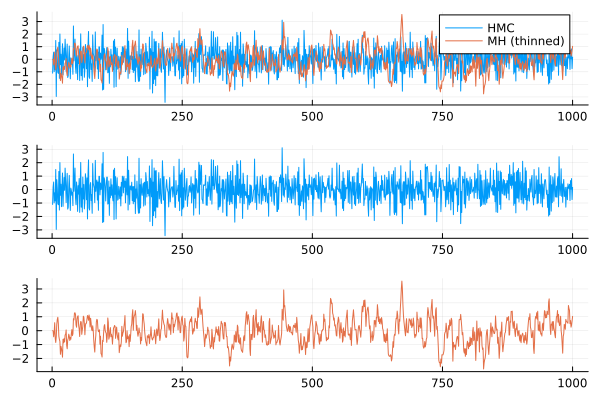

In [82]:
last_comp_hmc = [v[d] for v in samples_hmc]
last_comp_mh_th = [v[d] for v in samples_mh_thinned]

plot(last_comp_hmc, labels = "HMC")
p1 = plot!(last_comp_mh_th, labels = "MH (thinned)")

p2 = plot(last_comp_hmc, legend = false)

p3 = plot(last_comp_mh_th, color = 2, legend = false)

plot(p1, p2, p3, layout = (3, 1))

Plotting the sample variation over the component standard deviations, we see a fairly constant error for the HMC sampler (except for a little dip at the very end), while for the MH sampler, the error seems to increase with the standard deviation.

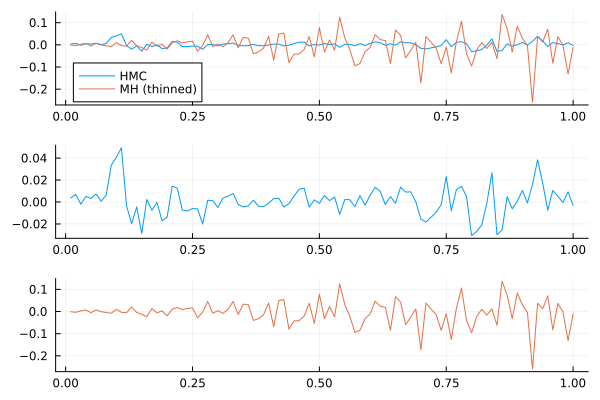

In [83]:
# Turns the vector of vectors inside-out (components outside, samples inside)
comps_hmc = [[v[i] for v in samples_hmc] for i = 1:d]
means_hmc = mean.(comps_hmc)
plot(sigmas, means_hmc, labels = "HMC")

comps_mh = [[v[i] for v in samples_mh] for i = 1:d]
means_mh = mean.(comps_mh)
p1 = plot!(sigmas, means_mh, labels = "MH (thinned)")

p2 = plot(sigmas, means_hmc, legend = false)

p3 = plot(sigmas, means_mh, color = 2, legend = false)

plot(p1, p2, p3, layout = (3, 1))